In [1]:
import wrapper as fitter

In [46]:
import numpy as np
import unittest
import copy
import pathlib

UNIT = 1e-3

MASS_DICT = {
    'K0_S': 497.611 * UNIT,
    'pi+': 139.57018 * UNIT,
    'D0': 1865.84 * UNIT,
    'phi': 1019.461 * UNIT,
    # 'pi0' : 134.9766,
}


def make_hist(data, range=None, nbins=100, density=False):
    if range is None:
        range = (np.min(data), np.max(data))
    dhist, dbins = np.histogram(data, bins=nbins, density=density, range=range)
    dbins = 0.5 * (dbins[1:] + dbins[:-1])
    norm = np.sum(dhist) / data.shape[0]
    errors = np.array([-0.5 + np.sqrt(dhist / norm + 0.25),
                       0.5 + np.sqrt(dhist / norm + 0.25)]) * norm
    return (dbins, dhist, errors)


def gamma(beta):
    """ Lorentz factor """
    return 1. / np.sqrt(1. - beta**2)


def lorentz_boost(lv, bv):
    """ Relativistic transformation """
    beta = np.linalg.norm(bv)
    gam, n = gamma(beta), bv / beta
    t, r = lv[:, 0].reshape(-1, 1), lv[:, 1:]
    return np.column_stack([gam * t - beta * np.dot(r, n.T),
                            r + (gam - 1) * np.dot(r, n.T) * n - gam * t * beta * n])


def energy(mass, p3):
    """ Energy from mass and 3-momentum """
    return np.sqrt(mass**2 + np.sum(p3**2, axis=-1))


def ks2pipi(N, pk=None):
    """ Generator of the Ks0 -> pi+ pi- decays """
    mks, mpi = [MASS_DICT[key] for key in ['K0_S', 'pi+']]
    epi = 0.5*mks
    ppi = np.sqrt(epi**2 - mpi**2)
    costh = 2.*np.random.rand(N) - 1
    phi = 2.*np.random.rand(N)*np.pi
    sinth = np.sqrt(1. - costh**2)
    sinphi, cosphi = np.sin(phi), np.cos(phi)
    p3pip = ppi*np.array([sinth*cosphi, sinth*sinphi, costh]).T

    if pk is not None:
        p4pip, p4pim = [np.empty((p3pip.shape[0], 4)) for _ in range(2)]
        p4pip[:, 0], p4pim[:, 0] = epi, epi
        p4pip[:, 1:], p4pim[:, 1:] = p3pip, -p3pip
        bv = -(pk.reshape(-1, 1) / energy(mks, pk)).T
        p4pip, p4pim = [lorentz_boost(x, bv) for x in [p4pip, p4pim]]
        return (p4pip[:, 1:], p4pim[:, 1:])

    return (p3pip, -p3pip)

In [47]:
def measurement_sampler(p3pip, p3pim, cov):
    """ Samples measurement error """
    assert cov.shape == (3, 3)
    N = p3pip.shape[0]
    dp = np.random.multivariate_normal([0, 0, 0], cov, 2*N)
    p3pip += dp[:N]
    p3pim += dp[N:]
    return (p3pip, p3pim)

def generate(N, cov, ptot=None):
    """ Generates N events for a given covariance matrix """
    p3pip, p3pim = ks2pipi(N, ptot)
    return (measurement_sampler(copy.deepcopy(p3pip), copy.deepcopy(p3pim), cov), p3pip, p3pim)

In [48]:
cov = (np.diag([3, 3, 5]) * 1e-3) ** 2

In [49]:
def generate_decay(cov, ptot=None):
    (p3pip, p3pim), p3pip_mc, p3pim_mc = generate(1, cov, ptot)
    return (p3pip[0], p3pim[0]), p3pip_mc[0], p3pim_mc[0]

In [80]:
# pip
mom_fit = []
mom_init = []
mom_mc = []
chis = []

EVENTS = 10000

for i in range(EVENTS):
    (p3pip, p3pim), p3pip_mc, p3pim_mc = generate_decay(cov)
    pip = fitter.Particle(211, momentum=p3pip)
    pim = fitter.Particle(-211, momentum=p3pim)
    kaon = fitter.Particle(311, daughters=[pip, pim])
    chi = kaon.fit()
    
    mom_mc.append(p3pip_mc)
    mom_init.append(p3pip)
    mom_fit.append(pip.momentum())
    chis.append(chi)

In [81]:
mom_fit = np.array(mom_fit)
mom_init = np.array(mom_init)
mom_mc = np.array(mom_mc)

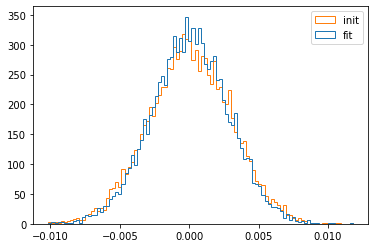

In [97]:
import matplotlib.pyplot as plt


plt.hist([mom_fit[:, 0] - mom_mc[:, 0], 
          mom_init[:, 0] - mom_mc[:, 0]], 
            bins=100, histtype='step', label=['fit', 'init']);
plt.legend()